In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib as plt
%load_ext memory_profiler

In [2]:
stats = pd.DataFrame(columns=['Read Time (ms)', 
                              'Write Time (ms)', 
                              'Disk Storage Space (MB)',
                              'Read Memory (MiB)',
                              'Write Memory (MiB)'
                             ],index=['csv', 'parquet'])

In [3]:
!ls -lh sample.csv

-rw-r--r--  1 dasa  staff   444M 21 Jul  2020 sample.csv


In [4]:
stats.loc['csv', 'Disk Storage Space (MB)'] = 444

In [5]:
%%time
df = pd.read_csv('sample.csv')

CPU times: user 6 s, sys: 1.12 s, total: 7.13 s
Wall time: 7.14 s


In [6]:
stats.loc['csv', 'Read Time (ms)'] = 7.14 * 1000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933771 entries, 0 to 933770
Columns: 120 entries, Product_ID to target_demand
dtypes: float64(118), int64(1), object(1)
memory usage: 854.9+ MB


In [18]:
df.head()

In [9]:
%%time
df.to_csv('sample.csv', index=False)

CPU times: user 1min 3s, sys: 1.46 s, total: 1min 5s
Wall time: 1min 5s


In [10]:
stats.loc['csv', 'Write Time (ms)'] = 65 * 1000

In [11]:
%%time
df.to_parquet('sample.parquet', index=False)

CPU times: user 3 s, sys: 551 ms, total: 3.55 s
Wall time: 3.04 s


In [12]:
stats.loc['parquet', 'Write Time (ms)'] = 3.04 * 1000

In [13]:
!ls -lh sample.parquet

-rw-r--r--  1 dasa  staff    30M  9 Feb 17:18 sample.parquet


In [14]:
stats.loc['parquet', 'Disk Storage Space (MB)'] = 30

In [15]:
%%time
df = pd.read_parquet('sample.parquet')

CPU times: user 1.74 s, sys: 1.63 s, total: 3.36 s
Wall time: 752 ms


In [16]:
stats.loc['parquet', 'Read Time (ms)'] = 752

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933771 entries, 0 to 933770
Columns: 120 entries, Product_ID to target_demand
dtypes: float64(118), int64(1), object(1)
memory usage: 854.9+ MB


# Statistics

In [18]:
stats[['Read Time (ms)', 'Write Time (ms)', 'Disk Storage Space (MB)']]

,Read Time (ms),Write Time (ms),Disk Storage Space (MB)
csv,7140,65000,444
parquet,752,3040,30


In [19]:
def annotate(ax):
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

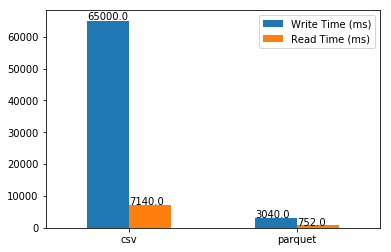

In [21]:
ax = stats[['Write Time (ms)', 'Read Time (ms)']].plot.bar(rot=0)
annotate(ax)

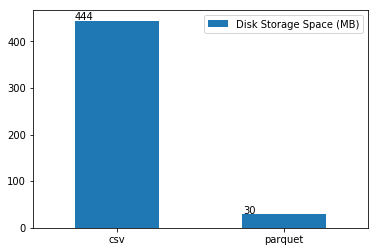

In [22]:
ax = stats[['Disk Storage Space (MB)']].plot.bar(rot=0)
annotate(ax)

# Disadvantages

## 1. Memory Usage in pandas

In [23]:
%%memit
df = pd.read_csv('sample.csv')

peak memory: 3111.98 MiB, increment: 1284.52 MiB


In [24]:
%%memit
df.to_csv('sample2.csv', index=False)

peak memory: 1915.59 MiB, increment: 15.32 MiB


In [25]:
%%memit
df.to_parquet('sample2.parquet', index=False)

peak memory: 1933.64 MiB, increment: 37.31 MiB


In [26]:
%%memit
df = pd.read_parquet('sample2.parquet')

peak memory: 3289.38 MiB, increment: 1445.83 MiB


In [32]:
stats.loc['csv', 'Read Memory (MiB)'] = 1284.52

In [33]:
stats.loc['csv', 'Write Memory (MiB)'] = 15.32

In [34]:
stats.loc['parquet', 'Write Memory (MiB)'] = 37.31

In [35]:
stats.loc['parquet', 'Read Memory (MiB)'] = 1445.83

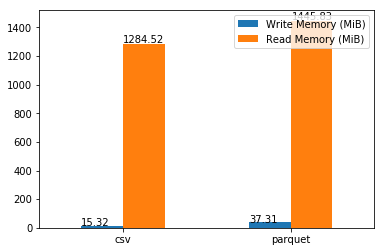

In [36]:
ax = stats[['Write Memory (MiB)','Read Memory (MiB)']].plot.bar(rot=0)
annotate(ax)

In [37]:
del df

## 2. No Chunksize operator in pd.read_parquet

In [38]:
chunked_df = pd.read_csv('sample.csv', chunksize=100000, iterator=True)

In [19]:
chunked_df.get_chunk(100000)

In [20]:
chunked_df.get_chunk(100000)

In [6]:
#chunked_df = pd.read_parquet('sample.parquet', chunksize=100000, iterator=True)

# Chunking a Parquet File

In [1]:
import pyarrow
import pyarrow.parquet as pq

In [5]:
!pip freeze | grep pyarrow

pyarrow==3.0.0


In [4]:
df = pd.read_csv('sample.csv')

#### Writing with row groups

In [7]:
table = pyarrow.Table.from_pandas(df, preserve_index=False)

In [11]:
pq.write_table(table, 'example.parquet', row_group_size=100000)

#### Reading with row groups

In [13]:
pq.ParquetFile('example.parquet').num_row_groups

10

In [21]:
pq.ParquetFile('example.parquet').read_row_group(0).to_pandas()

#### Reading with iter batches

In [3]:
pq.ParquetFile('example.parquet').iter_batches(batch_size=200000)

In [2]:
ls = []
for x in pq.ParquetFile('example.parquet').iter_batches(batch_size=200000):
    ls.append(x)

In [22]:
ls[0].to_pandas()

# Reading and writig files GCP Storage

#### Reading/Writing GCP Storage

In [14]:
import pandas
import gcsfs

In [16]:
!pip freeze | grep gcsfs

gcsfs==0.6.0


#### Read from GCP storage

In [10]:
path = '****'

fs = gcsfs.GCSFileSystem(token=path)
with fs.open("gs://path") as f:
    gcs_df = pandas.read_csv(f, usecols=[])
gcs_df

""


#### Write to GCP storage

In [11]:
with fs.open("gs://path", 'w') as f:
    gcs_df.to_csv(f, index=False)

# Read parquet file in dask

In [ ]:
import dask.dataframe as dd

#### Read the parquet file in chunks

In [ ]:
df = dd.read_parquet('example.parquet', chunksize=1000)

In [ ]:
df.head(npartitions=-1)

In [ ]:
df[df['movieId'] == 10].compute()

#### Creating a new column

In [ ]:
df['new_col'] = False

#### Setting the value of a cell based on a condition

In [ ]:
df["new_col"] = df.apply(lambda x: 'Hello' if(x["movieId"]==1) else False , axis=1)

# Create Partitons based on partition columns

### Write based on partition columns

In [ ]:
df.to_parquet('folder_name', partition_cols=['id'])
# for example if there are 2 ids then it will create two folder id=1 and id=2 in the givrl folder.
# ecah of the folders will contain the parquet file

#### Read based on partition columns

In [ ]:
import pyarrow
import pyarrow.parquet as pq
import os

In [ ]:
filepaths = os.listdir(path='folder_name') # Can also use glob
filepaths = sorted(filepaths)
filepaths

In [ ]:
dataset = pq.ParquetDataset('folder_name/id=1') # Can iterate over the ids

In [ ]:
table = dataset.read()

In [ ]:
table.to_pandas()